# Denoising Dirty Documents



**Mount the drive to colab notebook**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


**Import libraries and data**

In [ ]:
# import common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import zipfile
import os
import cv2
import keras
from tensorflow.keras.utils import plot_model

In [ ]:
# import Model libraries
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Activation, Dense, Input
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

%matplotlib inline

**Unzip Files**

In [ ]:
# Unzip Main File
path_zip = '/content/gdrive/MyDrive/Colab-Notebooks/project/'
path = '/content/gdrive/MyDrive/Colab-Notebooks/project/denoising-dirty-documents/'

with zipfile.ZipFile(path_zip + 'denoising-dirty-documents.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

In [ ]:
# Path to zipped & working directories
path_zip = '/content/gdrive/MyDrive/Colab-Notebooks/project/denoising-dirty-documents/'
path = '/content/gdrive/MyDrive/Colab-Notebooks/project/denoising-dirty-documents/'

In [ ]:
# Unzip files first to working directory
with zipfile.ZipFile(path_zip + 'train.zip', 'r') as zip_ref:
    zip_ref.extractall(path)

with zipfile.ZipFile(path_zip + 'test.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'train_cleaned.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  
    
with zipfile.ZipFile(path_zip + 'sampleSubmission.csv.zip', 'r') as zip_ref:
    zip_ref.extractall(path)  

In [ ]:
# store image names in list for later use
train_img = sorted(os.listdir(path + '/train'))
train_cleaned_img = sorted(os.listdir(path + '/train_cleaned'))
test_img = sorted(os.listdir(path + '/test'))

print (f'The train dataset has shape {len(train_img)} ')
print (f'The train dataset has shape {len(train_cleaned_img)} ')
print (f'The test dataset has shape {len(test_img)} ')

The train dataset has shape 144 
The test dataset has shape 144 
The test dataset has shape 72 


**Data preparation**

In [ ]:
# prepare function
def process_image(path):
    img = cv2.imread(path)
    img = np.asarray(img, dtype="float32")
    img = cv2.resize(img, (540, 420))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = img/255.0
    img = np.reshape(img, (420, 540, 1))
    
    return img

In [ ]:
# preprocess images
train = []
train_cleaned = []
test = []

for f in sorted(os.listdir(path + 'train/')):
    train.append(process_image(path + 'train/' + f))

for f in sorted(os.listdir(path + 'train_cleaned/')):
    train_cleaned.append(process_image(path + 'train_cleaned/' + f))
   
for f in sorted(os.listdir(path + 'test/')):
    test.append(process_image(path + 'test/' + f))

**Exploratory data analysis**

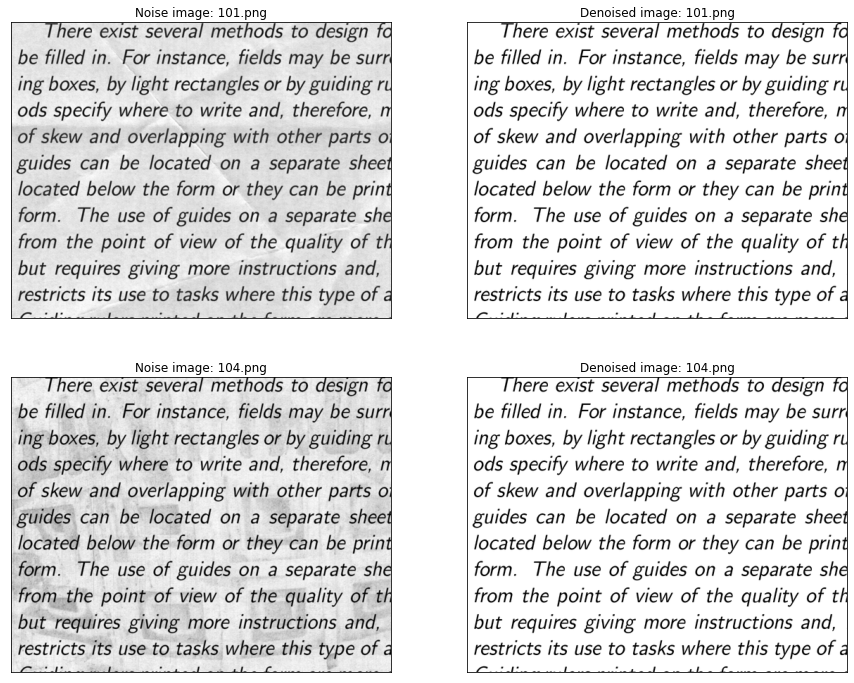

In [ ]:
# Plot a few samples
# First column will be raw data, second column will be the corresponding cleaned images
plt.figure(figsize=(15,25))
for i in range(0,4,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train[i][:,:,0], cmap='gray')
    plt.title('Noise image: {}'.format(train_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(train_cleaned[i][:,:,0], cmap='gray')
    plt.title('Denoised image: {}'.format(train_img[i]))

plt.show()

**Split data**

In [ ]:
# convert list to numpy array
X_train = np.asarray(train)
Y_train = np.asarray(train_cleaned)
X_test = np.asarray(test)


print (f'The train dataset has shape {X_train.shape} ')
print (f'The test dataset has shape {Y_train.shape} ')
print (f'The test dataset has shape {X_test.shape} ')

The train dataset has shape (144, 420, 540, 1) 
The test dataset has shape (144, 420, 540, 1) 
The test dataset has shape (72, 420, 540, 1) 


In [ ]:
#  split dataset into train and validation in ration 85% train, 15% test
# X_train, X_test, Y_train, Y_test
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.15)

**Modeling**

In [ ]:
# Define our autoencoder now
def model():
    input_img = Input(shape=(420, 540,1))

    #enoder 
    x = Conv2D(32, (3,3), activation='relu',kernel_regularizer = regularizers.l2(1e-5), padding='same')(input_img)
    #x = BatchNormalization()(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    x = Conv2D(32, (3,3), activation='relu',kernel_regularizer = regularizers.l2(1e-5), padding='same')(x)
    x = MaxPooling2D((2,2), padding='same')(x)
    
    x = Dropout(0.3)(x)

    #decoder
    x = Conv2D(64, (3,3), activation='relu',kernel_regularizer = regularizers.l2(1e-5), padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(32, (3,3), activation='relu',kernel_regularizer = regularizers.l2(1e-5), padding='same')(x)
    x = UpSampling2D((2,2))(x)
    x = Conv2D(1, (3,3), activation='sigmoid',kernel_regularizer = regularizers.l2(1e-5), padding='same')(x)
    #model
    model = Model(inputs=input_img, outputs=x)
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['mae'])
    return model


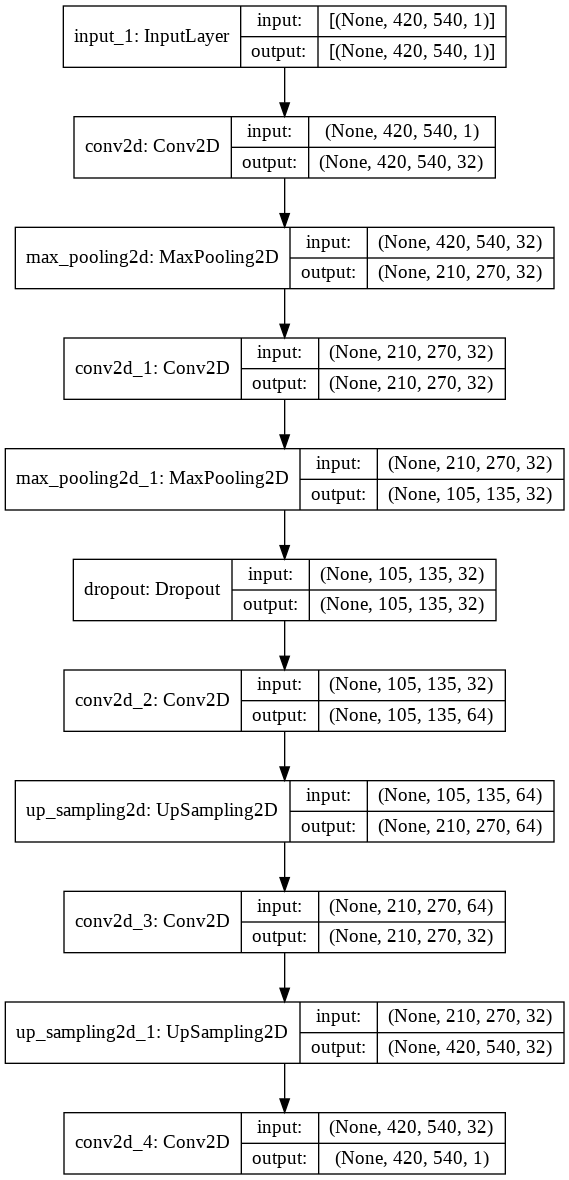

In [ ]:
model = model()
#model.summary()
plot_model (model, show_shapes=True)

**Train model**

Epoch 1/400
4/4 [==============================] - 46s 3s/step - loss: 0.6517 - mae: 0.4328 - val_loss: 0.5378 - val_mae: 0.3674
Epoch 2/400
4/4 [==============================] - 3s 718ms/step - loss: 0.4316 - mae: 0.2734 - val_loss: 0.3804 - val_mae: 0.1472
Epoch 3/400
4/4 [==============================] - 3s 717ms/step - loss: 0.4025 - mae: 0.1328 - val_loss: 0.3731 - val_mae: 0.1483
Epoch 4/400
4/4 [==============================] - 3s 758ms/step - loss: 0.3590 - mae: 0.1636 - val_loss: 0.3624 - val_mae: 0.2117
Epoch 5/400
4/4 [==============================] - 3s 721ms/step - loss: 0.3620 - mae: 0.2138 - val_loss: 0.3652 - val_mae: 0.2184
Epoch 6/400
4/4 [==============================] - 3s 722ms/step - loss: 0.3525 - mae: 0.1965 - val_loss: 0.3493 - val_mae: 0.1744
Epoch 7/400
4/4 [==============================] - 3s 723ms/step - loss: 0.3483 - mae: 0.1597 - val_loss: 0.3513 - val_mae: 0.1606
Epoch 8/400
4/4 [==============================] - 3s 719ms/step - loss: 0.3462 - mae

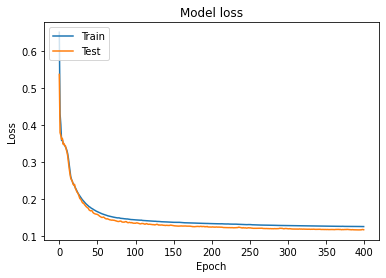

In [ ]:
# Train our model
callback = EarlyStopping(monitor='val_loss', min_delta=0,patience=20,verbose=1,mode='auto')
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=400, batch_size=32, verbose=1, callbacks=[callback])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

**Plot error evolution on epochs**

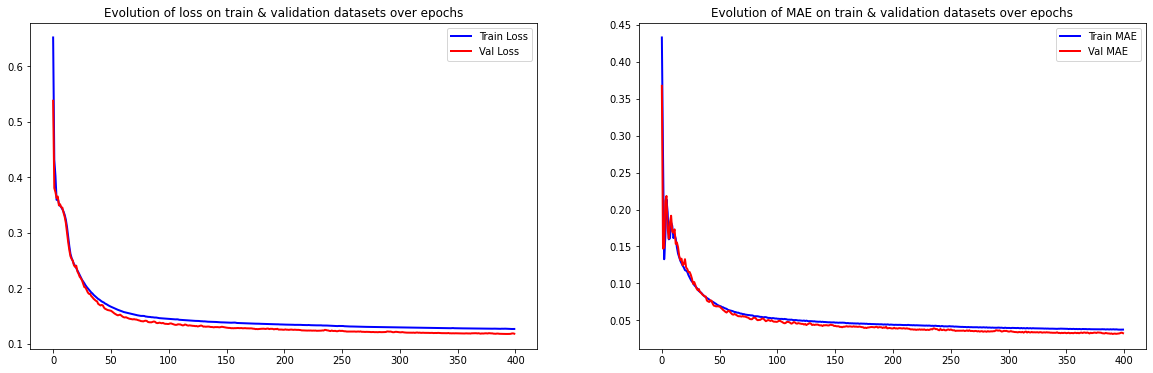

In [ ]:
# Check how loss & mae went down
epoch_loss = history.history['loss']
epoch_val_loss = history.history['val_loss']
epoch_mae = history.history['mae']
epoch_val_mae = history.history['val_mae']

plt.figure(figsize=(20,6))
plt.subplot(1,2,1)
plt.plot(range(0,len(epoch_loss)), epoch_loss, 'b-', linewidth=2, label='Train Loss')
plt.plot(range(0,len(epoch_val_loss)), epoch_val_loss, 'r-', linewidth=2, label='Val Loss')
plt.title('Evolution of loss on train & validation datasets over epochs')
plt.legend(loc='best')

plt.subplot(1,2,2)
plt.plot(range(0,len(epoch_mae)), epoch_mae, 'b-', linewidth=2, label='Train MAE')
plt.plot(range(0,len(epoch_val_mae)), epoch_val_mae, 'r-', linewidth=2,label='Val MAE')
plt.title('Evolution of MAE on train & validation datasets over epochs')
plt.legend(loc='best')

plt.show()

**Evaluation**

In [ ]:
# predict/clean test images
Y_test = model.predict(X_test, batch_size=32)

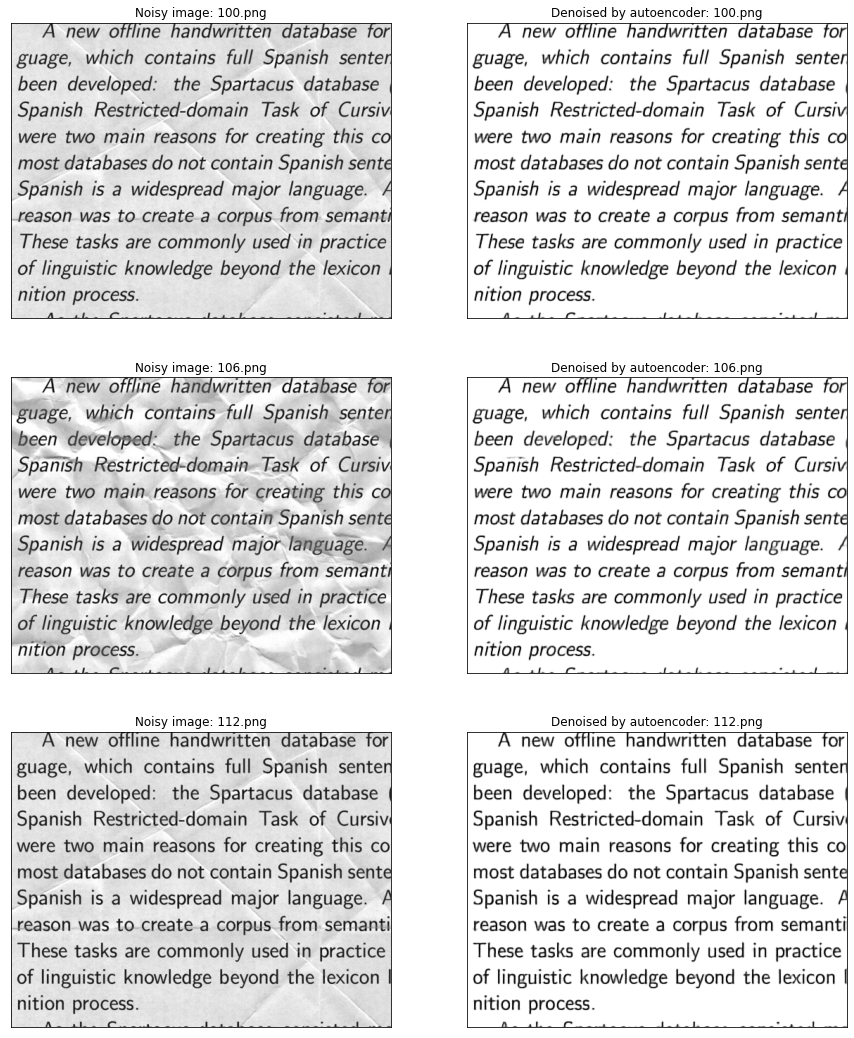

In [ ]:
plt.figure(figsize=(15,25))
for i in range(2,8,2):
    plt.subplot(4,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test[i][:,:,0], cmap='gray')
    plt.title('Noisy image: {}'.format(test_img[i]))
    
    plt.subplot(4,2,i+2)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(Y_test[i][:,:,0], cmap='gray')
    plt.title('Denoised by autoencoder: {}'.format(test_img[i]))

plt.show()